<a href="https://colab.research.google.com/github/Alsuyav/Image_classification/blob/main/image_classification.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Классификация изображений
200 классов

~ 5000 объектов

Структура датасета -- есть директории train/ и val/, в которых лежат обучающие и валидационные данные. В train/ и val/ лежат директориии, соответствующие классам изображений, в которых лежат, собственно, сами изображения.

Задача:

1) Создать модель для классификации изображений

## Загрузка, установка и импорт

In [ ]:
# %%capture
!pip install wandb
!pip3 install pytorch_lightning torchmetrics
!pip install -U albumentations
!wget https://www.dropbox.com/s/33l8lp62rmvtx40/dataset.zip?dl=1 -O dataset.zip && unzip -q dataset.zip

--2023-10-20 07:04:17--  https://www.dropbox.com/s/33l8lp62rmvtx40/dataset.zip?dl=1
Resolving www.dropbox.com (www.dropbox.com)... 162.125.5.18, 2620:100:601d:18::a27d:512
Connecting to www.dropbox.com (www.dropbox.com)|162.125.5.18|:443... connected.
HTTP request sent, awaiting response... 302 Found
Location: /s/dl/33l8lp62rmvtx40/dataset.zip [following]
--2023-10-20 07:04:18--  https://www.dropbox.com/s/dl/33l8lp62rmvtx40/dataset.zip
Reusing existing connection to www.dropbox.com:443.
HTTP request sent, awaiting response... 302 Found
Location: https://uc882c3b69e5658fc30f2421ba53.dl.dropboxusercontent.com/cd/0/get/CF9g-xFSYCAGUuFH-dCpSgM3oaGw8Lyz_4DiH-0ofdEVzn_dhBUbSSNLFnE-lAmOs7dqTjC9rgSPZSZsXtgj_3sUbvocJqf072d3ltyK3lC1c7yWz-pHklJc5MN-4LrA38-O8_kalGHhghM2c3DtAhkS/file?dl=1# [following]
--2023-10-20 07:04:18--  https://uc882c3b69e5658fc30f2421ba53.dl.dropboxusercontent.com/cd/0/get/CF9g-xFSYCAGUuFH-dCpSgM3oaGw8Lyz_4DiH-0ofdEVzn_dhBUbSSNLFnE-lAmOs7dqTjC9rgSPZSZsXtgj_3sUbvocJqf072d3lty

In [ ]:
import math
import os
import random
import sys
import glob
import cv2

import albumentations as A
from albumentations.pytorch import ToTensorV2
import matplotlib.pyplot as plt
from pandas.core.common import flatten
import numpy as np
import pytorch_lightning as pl
import torch
import torchvision
import torchvision.transforms as transforms
from PIL import Image
from pytorch_lightning.loggers import WandbLogger
from torch import nn
from torch.nn import functional as F
from torch.utils.data import Dataset, DataLoader
from torchmetrics.functional import accuracy
from torchvision.datasets import ImageFolder
from tqdm import tqdm

In [ ]:
import wandb
wandb.login()

wandb: Currently logged in as: alsuyav. Use `wandb login --relogin` to force relogin


True

In [ ]:
def seed_everything(seed):
    # Фискирует максимум сидов
    random.seed(seed)
    os.environ["PYTHONHASHSEED"] = str(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed(seed)
    torch.backends.cudnn.deterministic = True

seed_everything(123456)

## Подготовка данных

In [ ]:
# пути до обучающей и валидационной выборок
train_path = "/content/dataset/dataset/train"
val_path = "/content/dataset/dataset/val"

# списки путей до обучающих и тестовых картинок
train_paths = []
val_paths = []
# список классов
classes = []

# заполнение списков train_paths и classes
for data_path in glob.glob(train_path + '/*'):
    classes.append(data_path.split('/')[-1])
    train_paths.append(glob.glob(data_path + '/*'))
train_paths = list(flatten(train_paths))

# перемешивание обучающих картинок
random.shuffle(train_paths)

# заполнение списка val_paths
for data_path in glob.glob(val_path + '/*'):
    val_paths.append(glob.glob(data_path + '/*'))
val_paths = list(flatten(val_paths))

small_train_paths = train_paths[int(0.9*len(train_paths)):]


print("Train size: {}\nSmall_train size: {}\nValid size: {}".format(len(train_paths), len(small_train_paths), len(val_paths)))

Train size: 100000
Small_train size: 10000
Valid size: 10000


In [ ]:
# словари для классов - для сопоставления классов с индексами и индексами с классами
idx_to_class = {i:j for i, j in enumerate(classes)}
class_to_idx = {value:key for key,value in idx_to_class.items()}

In [ ]:
# класс для данных
class OurDataset(Dataset):
    def __init__(self, image_paths, transform=False):
        self.image_paths = image_paths
        self.transform = transform

    def __len__(self):
        return len(self.image_paths)

    def __getitem__(self, idx):
        image_filepath = self.image_paths[idx]
        image = cv2.imread(image_filepath)
        image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)

        label = image_filepath.split('/')[-2]
        label = class_to_idx[label]
        if self.transform is not None:
            image = self.transform(image=image)["image"]

        return image, label

In [ ]:
# обработка
train_transform = A.Compose(
    [
        # аффинные преобразования: сдвиг, масштабирование, вращение
        A.ShiftScaleRotate(shift_limit=0.03, scale_limit=0.05, rotate_limit=60, p=0.4),
        # сдвиг значений для каждого канала входного изображения RGB
        A.RGBShift(r_shift_limit=16, g_shift_limit=16, b_shift_limit=16, p=0.5),
        # изменение яркости и контрастности входного изображения
        A.RandomBrightnessContrast(brightness_limit=0.1, contrast_limit=0.1, p=0.4),
        # умножение изображения на случайное число или массив чисел
        A.MultiplicativeNoise(multiplier=[0.5,0.9], per_channel=True, p=0.3),
        # изменение оттенка, насыщенности и значения входного изображения
        A.HueSaturationValue(hue_shift_limit=0.2, sat_shift_limit=0.2, val_shift_limit=0.2, p=0.3),
        # нормализация
        A.Normalize(mean=(0.544268535904948, 0.5078093085177952, 0.4505041277235243), std=(0.260139962956694, 0.2563979034887267, 0.25556574095234724)),
        # перевод в тензор
        ToTensorV2(),
    ]
)
val_transform = A.Compose(
    [
        A.Normalize(mean=(0.544268535904948, 0.5078093085177952, 0.4505041277235243), std=(0.260139962956694, 0.2563979034887267, 0.25556574095234724)),
        ToTensorV2()
    ]
)

train_dataset = OurDataset(train_paths, train_transform)
small_train_dataset = OurDataset(small_train_paths, train_transform)
val_dataset = OurDataset(val_paths, val_transform)

train_dataloader = DataLoader(train_dataset, batch_size=32, shuffle=True, num_workers=1)
small_train_dataloader = DataLoader(small_train_dataset, batch_size=32, shuffle=True, num_workers=1)
val_dataloader = DataLoader(val_dataset, batch_size=32, shuffle=False, num_workers=1)

In [ ]:
# Небольшая проверка
assert isinstance(train_dataset[0], tuple)
assert len(train_dataset[0]) == 2
assert isinstance(train_dataset[1][1], int)
print("tests passed")

tests passed


### Объекты

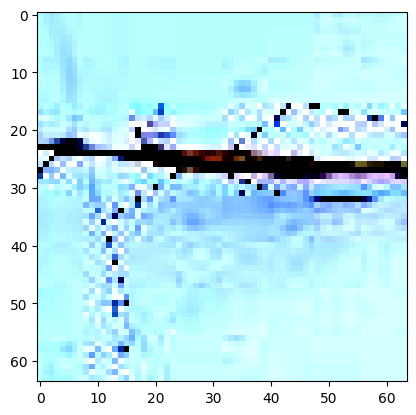

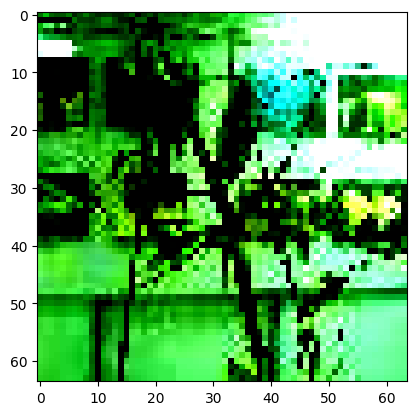

In [ ]:
for batch in val_dataloader:
    images, class_nums = batch
    for i in range(18, 20):
      plt.imshow(images[i].permute(1, 2, 0))
      plt.show()
    break

## Модель

### Тренировочный класс lightning

In [ ]:
from torchvision.models import resnet18

In [ ]:
class YourModule(pl.LightningModule):
    def __init__(self, model, learning_rate) -> None:
        super().__init__()
        self.model = model
        self.learning_rate = learning_rate
        self.optimizer = torch.optim.Adam(self.model.parameters(), lr=learning_rate)
        # self.scheduler = torch.optim.lr_scheduler.StepLR(self.optimizer, step_size=10, gamma=0.7)
        self.loss = nn.CrossEntropyLoss()
        self.save_hyperparameters(ignore=['model'])

    def forward(self, x) -> torch.Tensor:
        preds = self.model(x)
        return preds

    def configure_optimizers(self):
        return self.optimizer

    def training_step(self, train_batch, batch_idx) -> torch.Tensor:
        images, target = train_batch
        preds = self.forward(images)
        loss = self.loss(preds, target)
        acc = accuracy(torch.argmax(preds, dim=-1).long(), target.long(), task="multiclass", num_classes=200)
        self.log('train_loss', loss)
        self.log('train_accuracy', acc)
        return loss

    def validation_step(self, val_batch, batch_idx) -> None:
        images, target = val_batch
        preds = self.forward(images)
        loss = self.loss(preds, target)
        acc = accuracy(torch.argmax(preds, dim=-1).long(), target.long(), task="multiclass", num_classes=200)
        self.log('val_loss', loss)
        self.log('val_accuracy', acc)

In [ ]:
wandb_logger = WandbLogger("reset18 without pretraining, Adam, StepLR, lr=0.01",
                           project="Classification200-0.2",
                           log_model='all') #  https://docs.wandb.ai/guides/integrations/lightning
device = "cuda:0" if torch.cuda.is_available() else "cpu"

model = resnet18(weights=None)
model.fc = nn.Linear(512, 200)
module = YourModule(model, 0.01)

wandb.init(project="Classification200-0.2")
wandb.watch(model)

[]

In [ ]:
trainer = pl.Trainer(logger=wandb_logger, max_epochs=25)
trainer.fit(module, train_dataloader, val_dataloader)

INFO:pytorch_lightning.utilities.rank_zero:GPU available: True (cuda), used: True
INFO:pytorch_lightning.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO:pytorch_lightning.utilities.rank_zero:IPU available: False, using: 0 IPUs
INFO:pytorch_lightning.utilities.rank_zero:HPU available: False, using: 0 HPUs
/usr/local/lib/python3.10/dist-packages/pytorch_lightning/loggers/wandb.py:389: There is a wandb run already in progress and newly created instances of `WandbLogger` will reuse this run. If this is not desired, call `wandb.finish()` before instantiating `WandbLogger`.
INFO:pytorch_lightning.accelerators.cuda:LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
INFO:pytorch_lightning.callbacks.model_summary:
  | Name  | Type             | Params
-------------------------------------------
0 | model | ResNet           | 11.3 M
1 | loss  | CrossEntropyLoss | 0     
-------------------------------------------
11.3 M    Trainable params
0         Non-trainable params
11.3 M    Total 

Sanity Checking: |          | 0/? [00:00<?, ?it/s]

/usr/local/lib/python3.10/dist-packages/pytorch_lightning/trainer/connectors/data_connector.py:441: The 'val_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=1` in the `DataLoader` to improve performance.
/usr/local/lib/python3.10/dist-packages/pytorch_lightning/trainer/connectors/data_connector.py:441: The 'train_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=1` in the `DataLoader` to improve performance.


Training: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

/usr/local/lib/python3.10/dist-packages/pytorch_lightning/trainer/call.py:54: Detected KeyboardInterrupt, attempting graceful shutdown...
